# Example Usage for Cleaning Stimulation Pulses with Zappy

# Main Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

import zappy

# Load Data

In [ ]:
def get_stim_data():
    from tqdm import tqdm
    import wget
    import zipfile
    import os
    
    url = "https://www.dropbox.com/sh/yqf36798y1yz9e8/AACcqZdu09Chlvkr1NOFFsiQa?dl=1"
    out = './stim_24k.zip'
    fname = './data/EC206_B18_stim_example.npz'
    if not os.path.exists(fname):
        if not os.path.exists(out):
            print('Downloading sample data...')
            wget.download(url, out=out, bar=wget.bar_thermometer)
        
        print('Extracting sample data...')
        with zipfile.ZipFile(out, 'r') as zipObj:
            zipObj.extractall('./data')
            
        os.remove(out)
            
    npz = zappy.io.sigdict.load_data_dict(fname)
    print('Loaded sample data.')    
    
    return npz

# Download / load-in sample data
npz = get_stim_data()

# Get data sizes
n_time = npz['stim'].shape[0]
n_stim = npz['stim'].shape[1]
tstamp = np.arange(0, n_time / npz['Fs'], 1/npz['Fs'])

# Visualize Stimulation Pulses 

## Full Stim Sequence

In [ ]:
plt.figure(figsize=(24,12))
for i in range(n_stim):
    ax = plt.subplot(n_stim, 1, i+1)
    ax.plot(tstamp, npz['stim'][:,i])
    ax.set_ylim([-2500, 2500])
    
    if i < (n_stim-1):
        ax.set_xticks([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Stim Current (uA)')

## Zoomed-In Plot

In [ ]:
plt.figure(figsize=(24,12))
for i in range(n_stim):
    ax = plt.subplot(n_stim, 1, i+1)
    ax.plot(tstamp, npz['stim'][:,i])
    ax.set_ylim([-2500, 2500])
    
    if i < (n_stim-1):
        ax.set_xticks([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Stim Current (uA)')
    
    ax.set_xlim([45, 52])

In [2]:
sseq = np.load('/Users/akhambhati/Hoth/Remotes/CORE.VNS_Test.wschuerman/tVNS_30Hz/stim.npy')
sig_sham = np.load('/Users/akhambhati/Hoth/Remotes/CORE.VNS_Test.wschuerman/tVNS_30Hz/sig_sham.npy')
sig = np.load('/Users/akhambhati/Hoth/Remotes/CORE.VNS_Test.wschuerman/tVNS_30Hz/LFP.npy')

Fs = 24000
tstamp = np.arange(sig.shape[0]) / Fs

# Run Zappy

Locating stimulation pulses from input sequence...
Determining non-pulse periods to use as control...
Clipping and aggregating iEEG around stim pulses...
Clipping and aggregating iEEG around non-stim pulses...
Training ICA models on stim pulses and non-stim pulses...


/Users/akhambhati/Dev/miniconda3/envs/hoth/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Calculating summary statistic on distribution of ICs...
Reconstructing iEEG of stim pulses after removing corrupt components...
Independent Components of Stim Pulses...


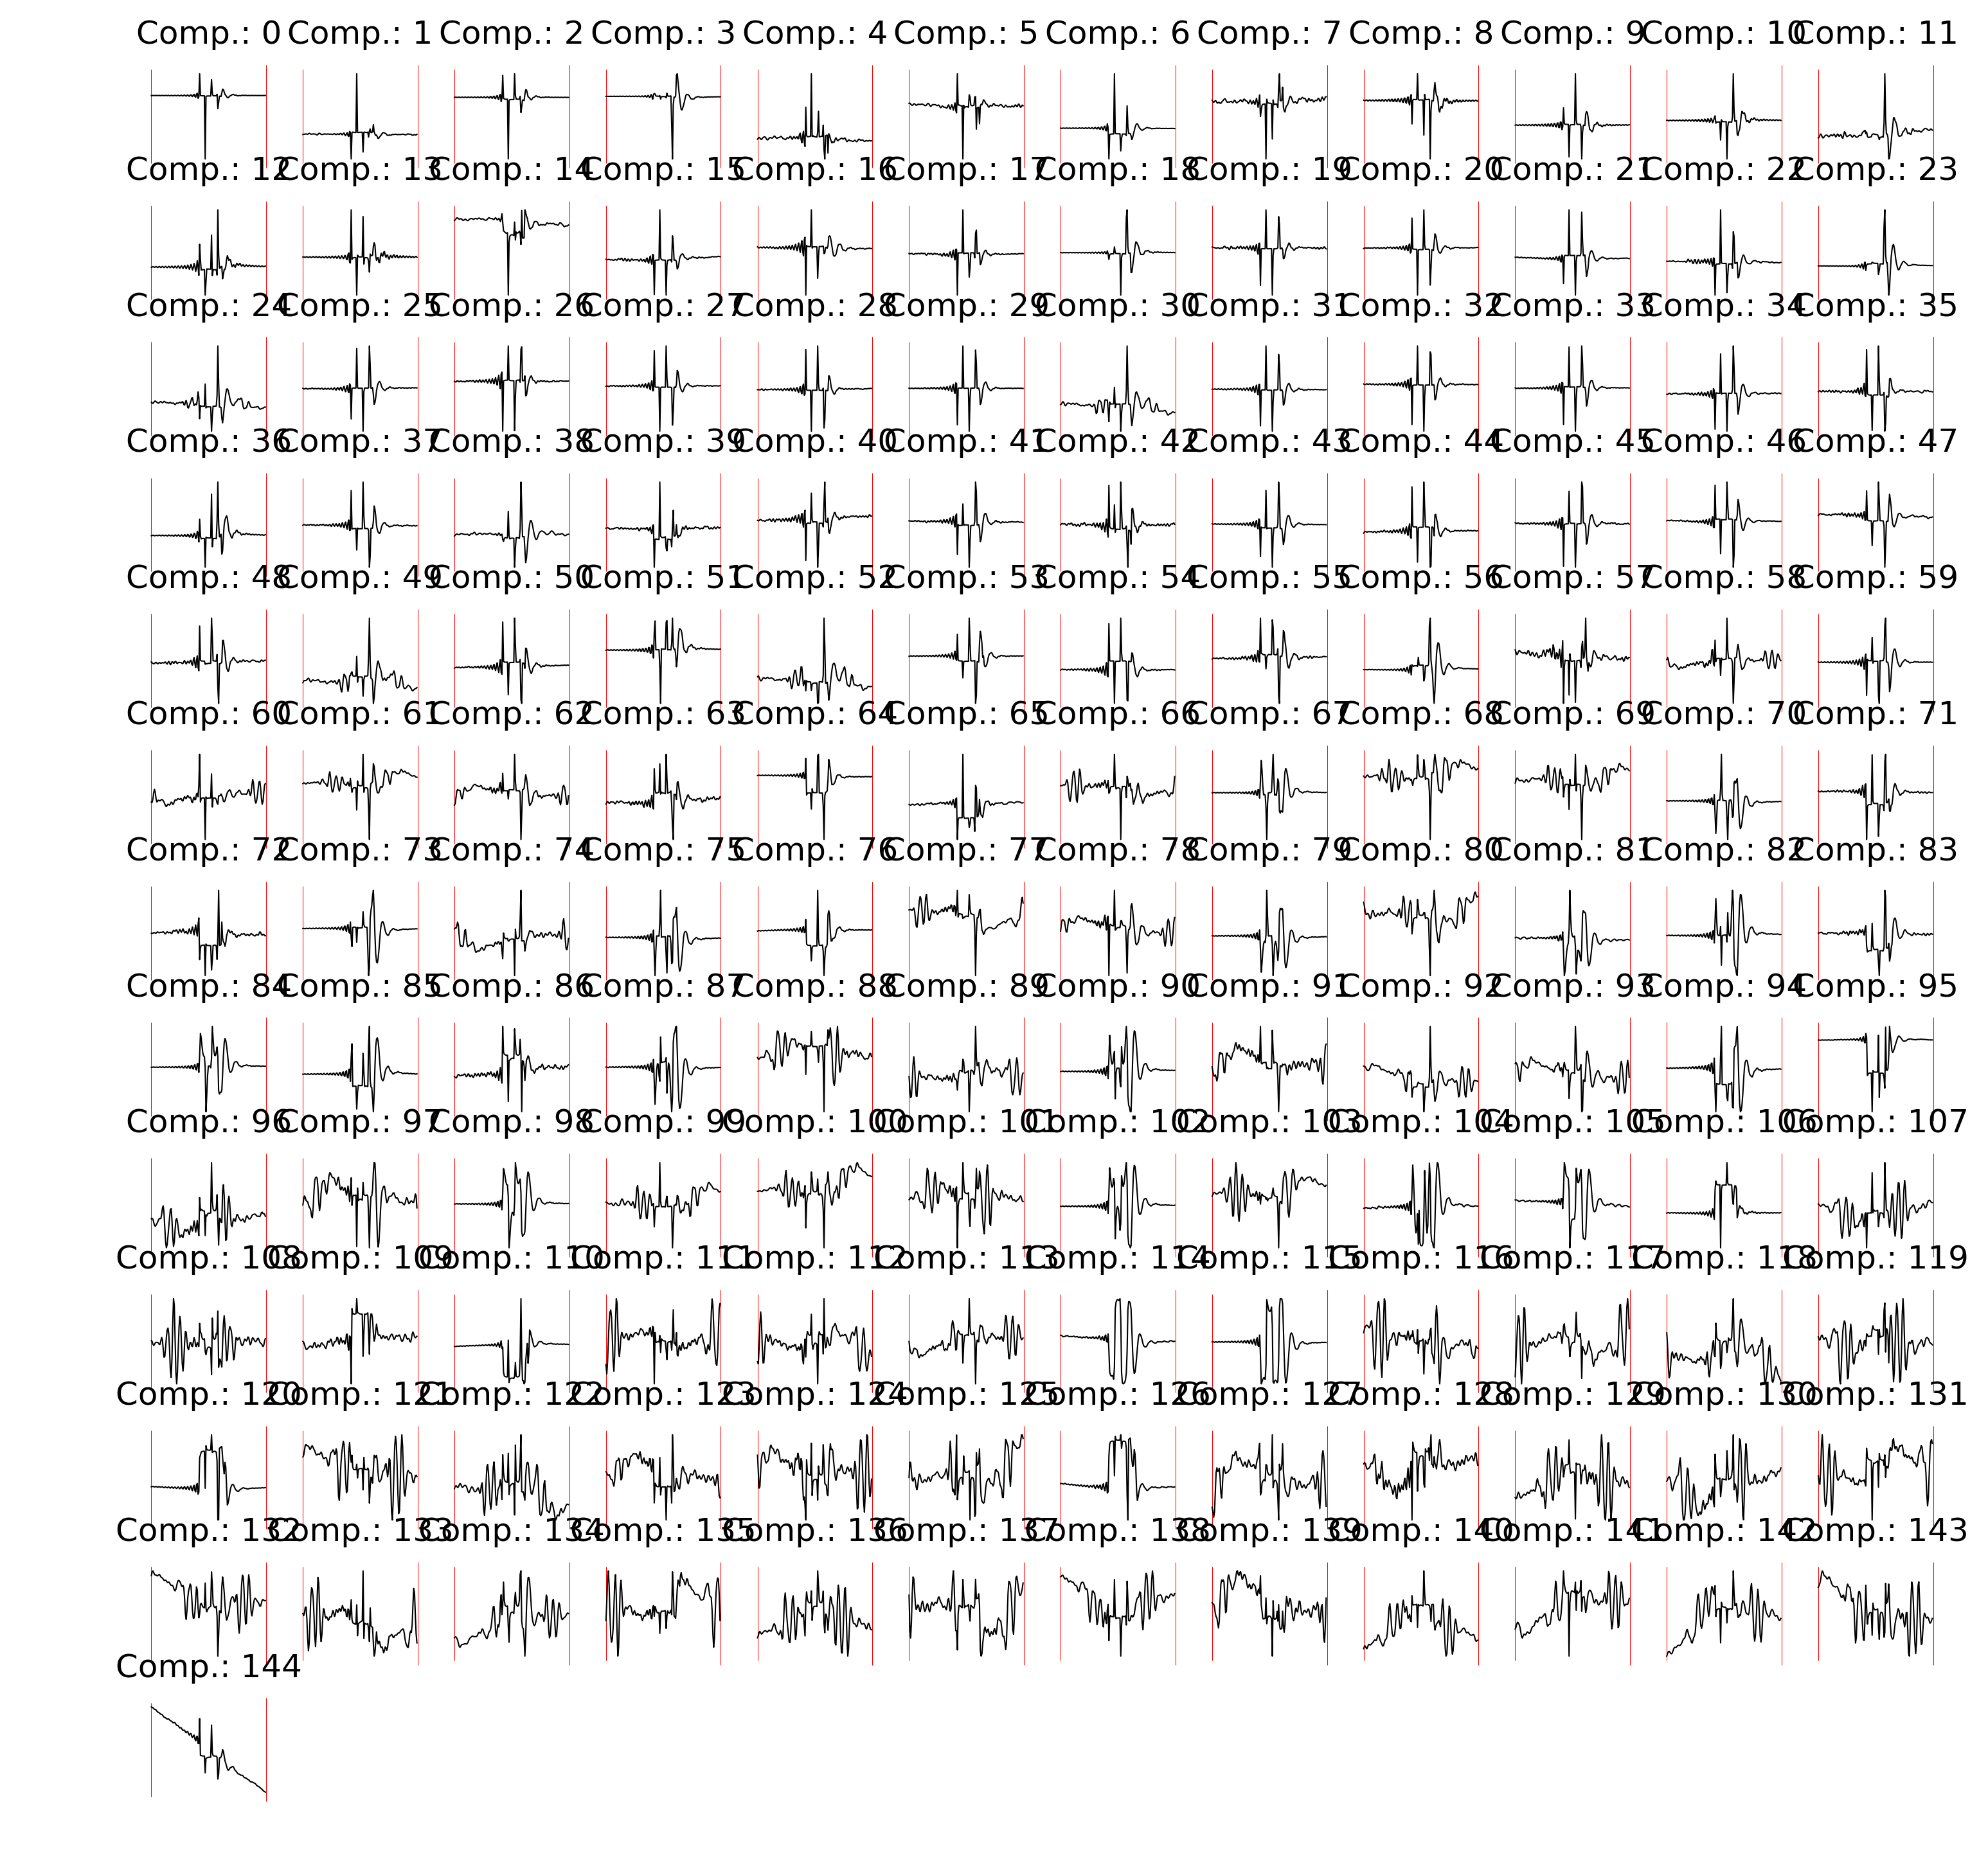

Independent Components of Non-Stim Pulses...


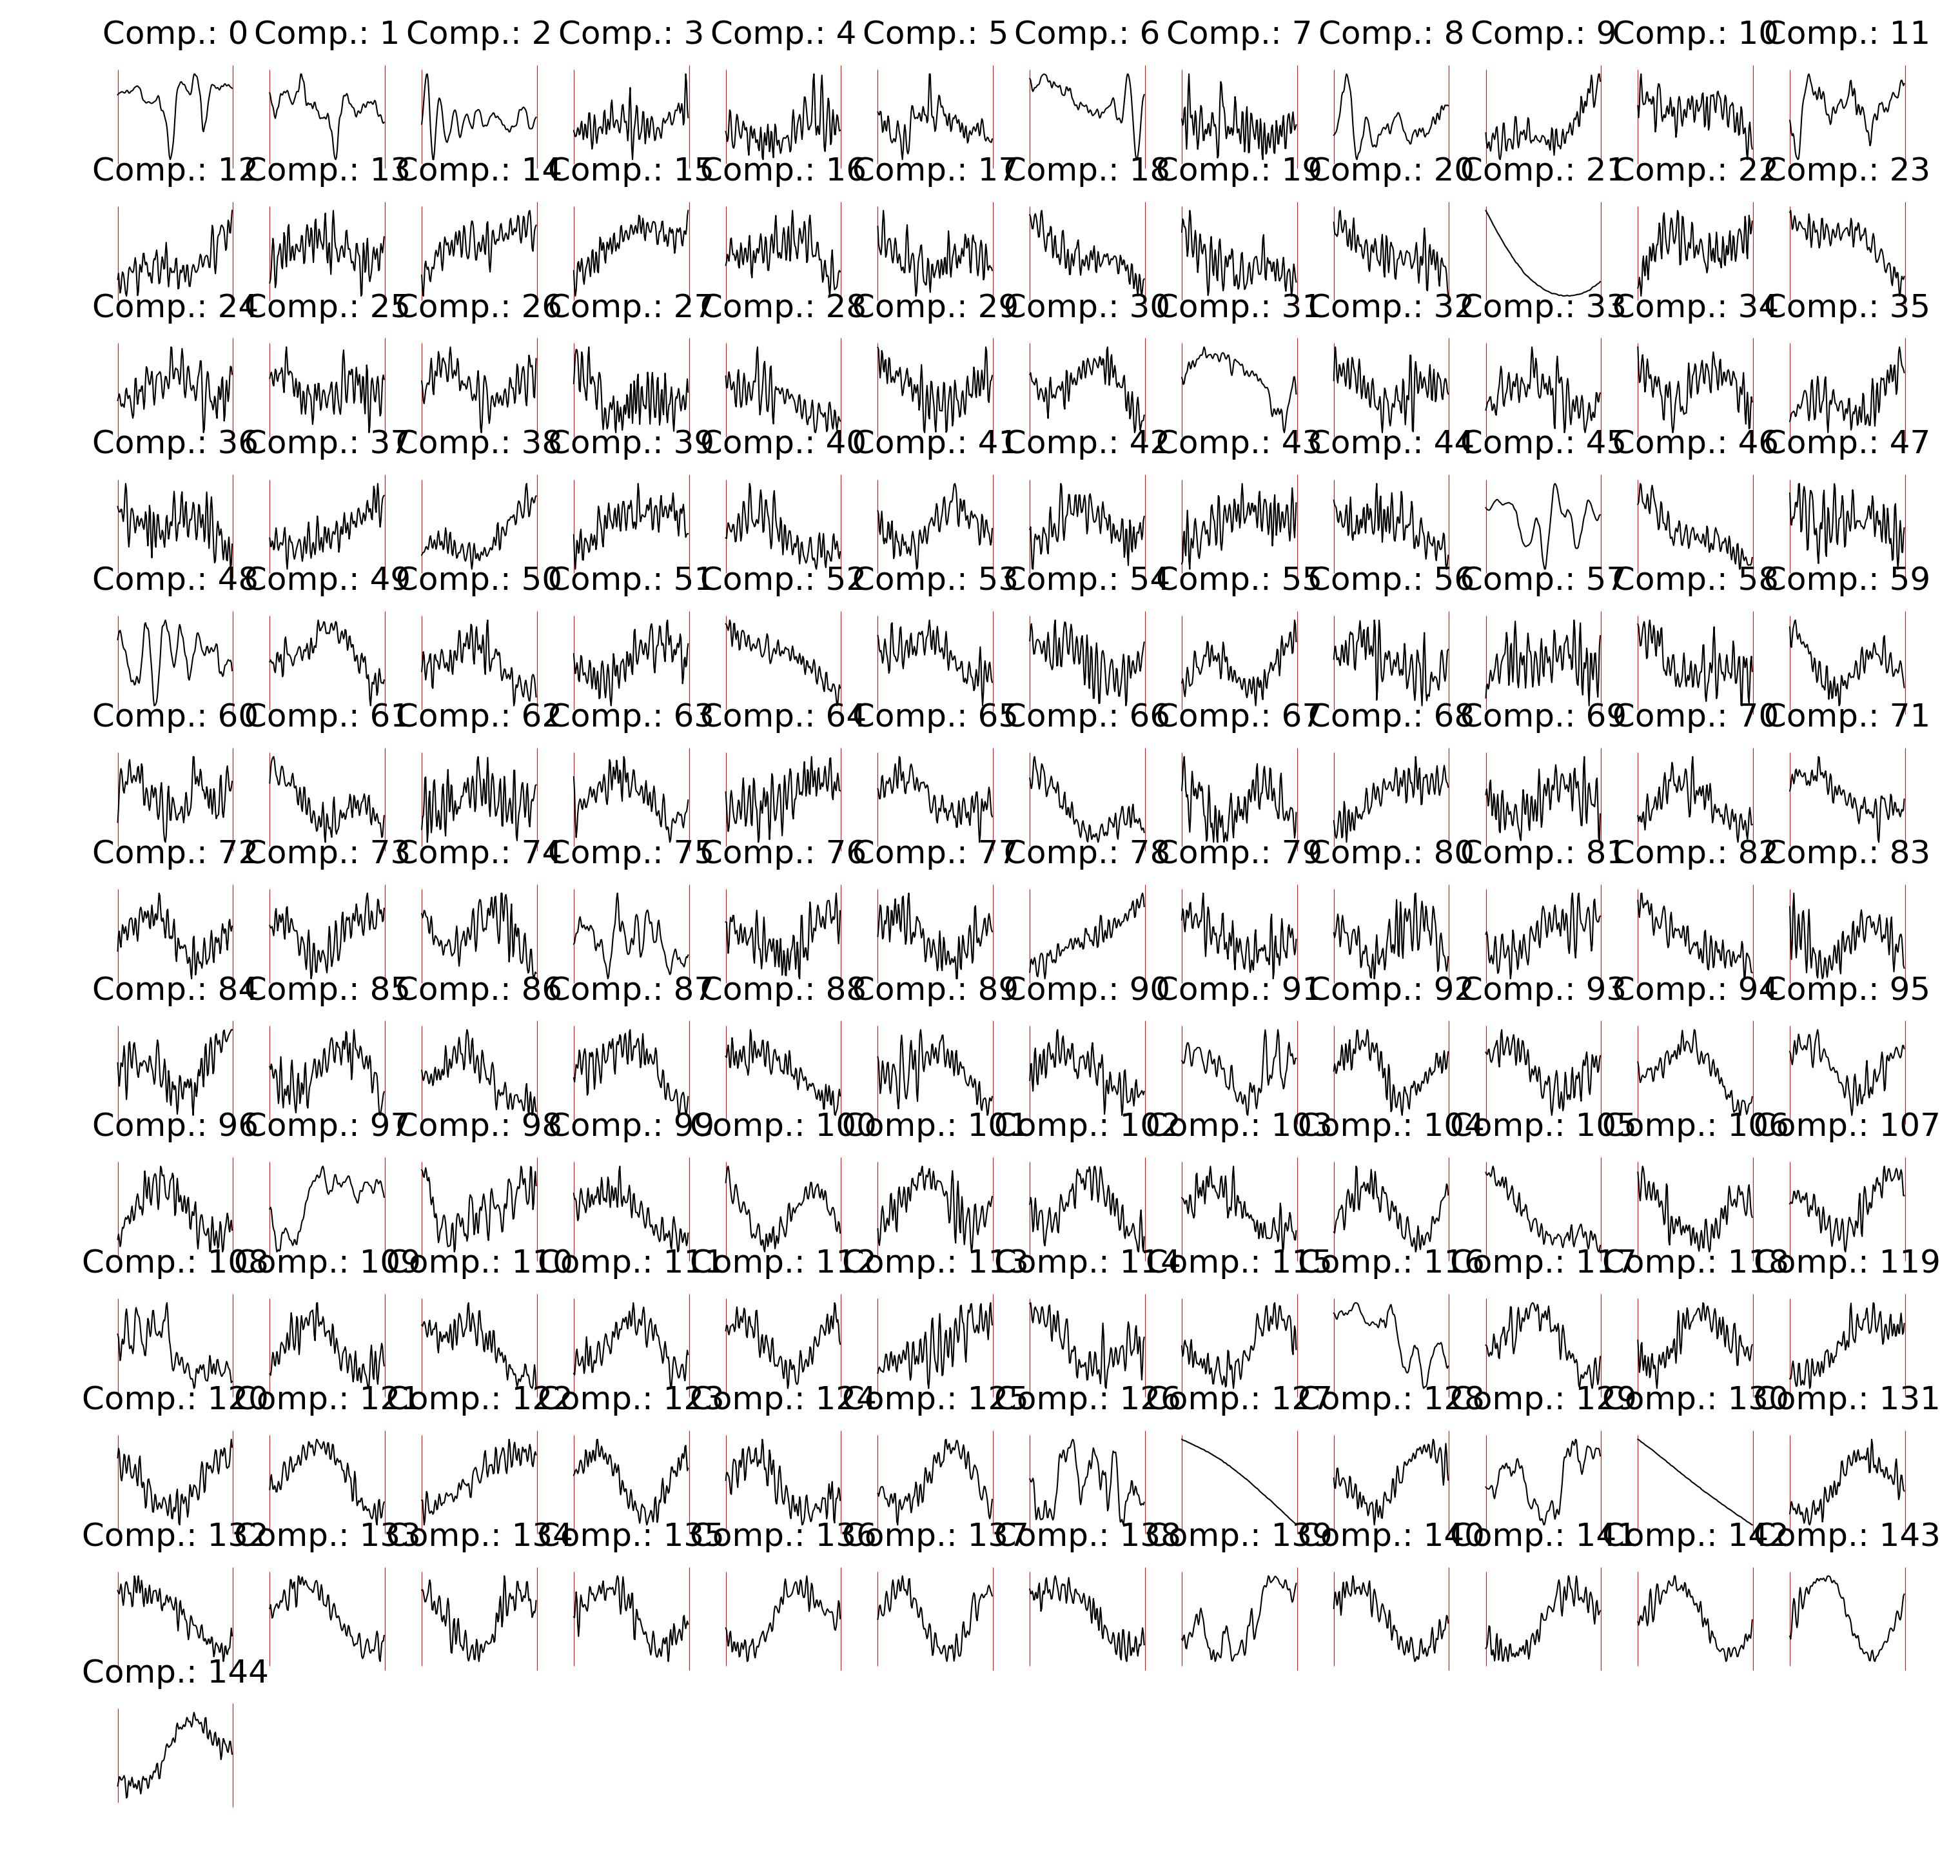

Distribution of summary stat values for IC removal...


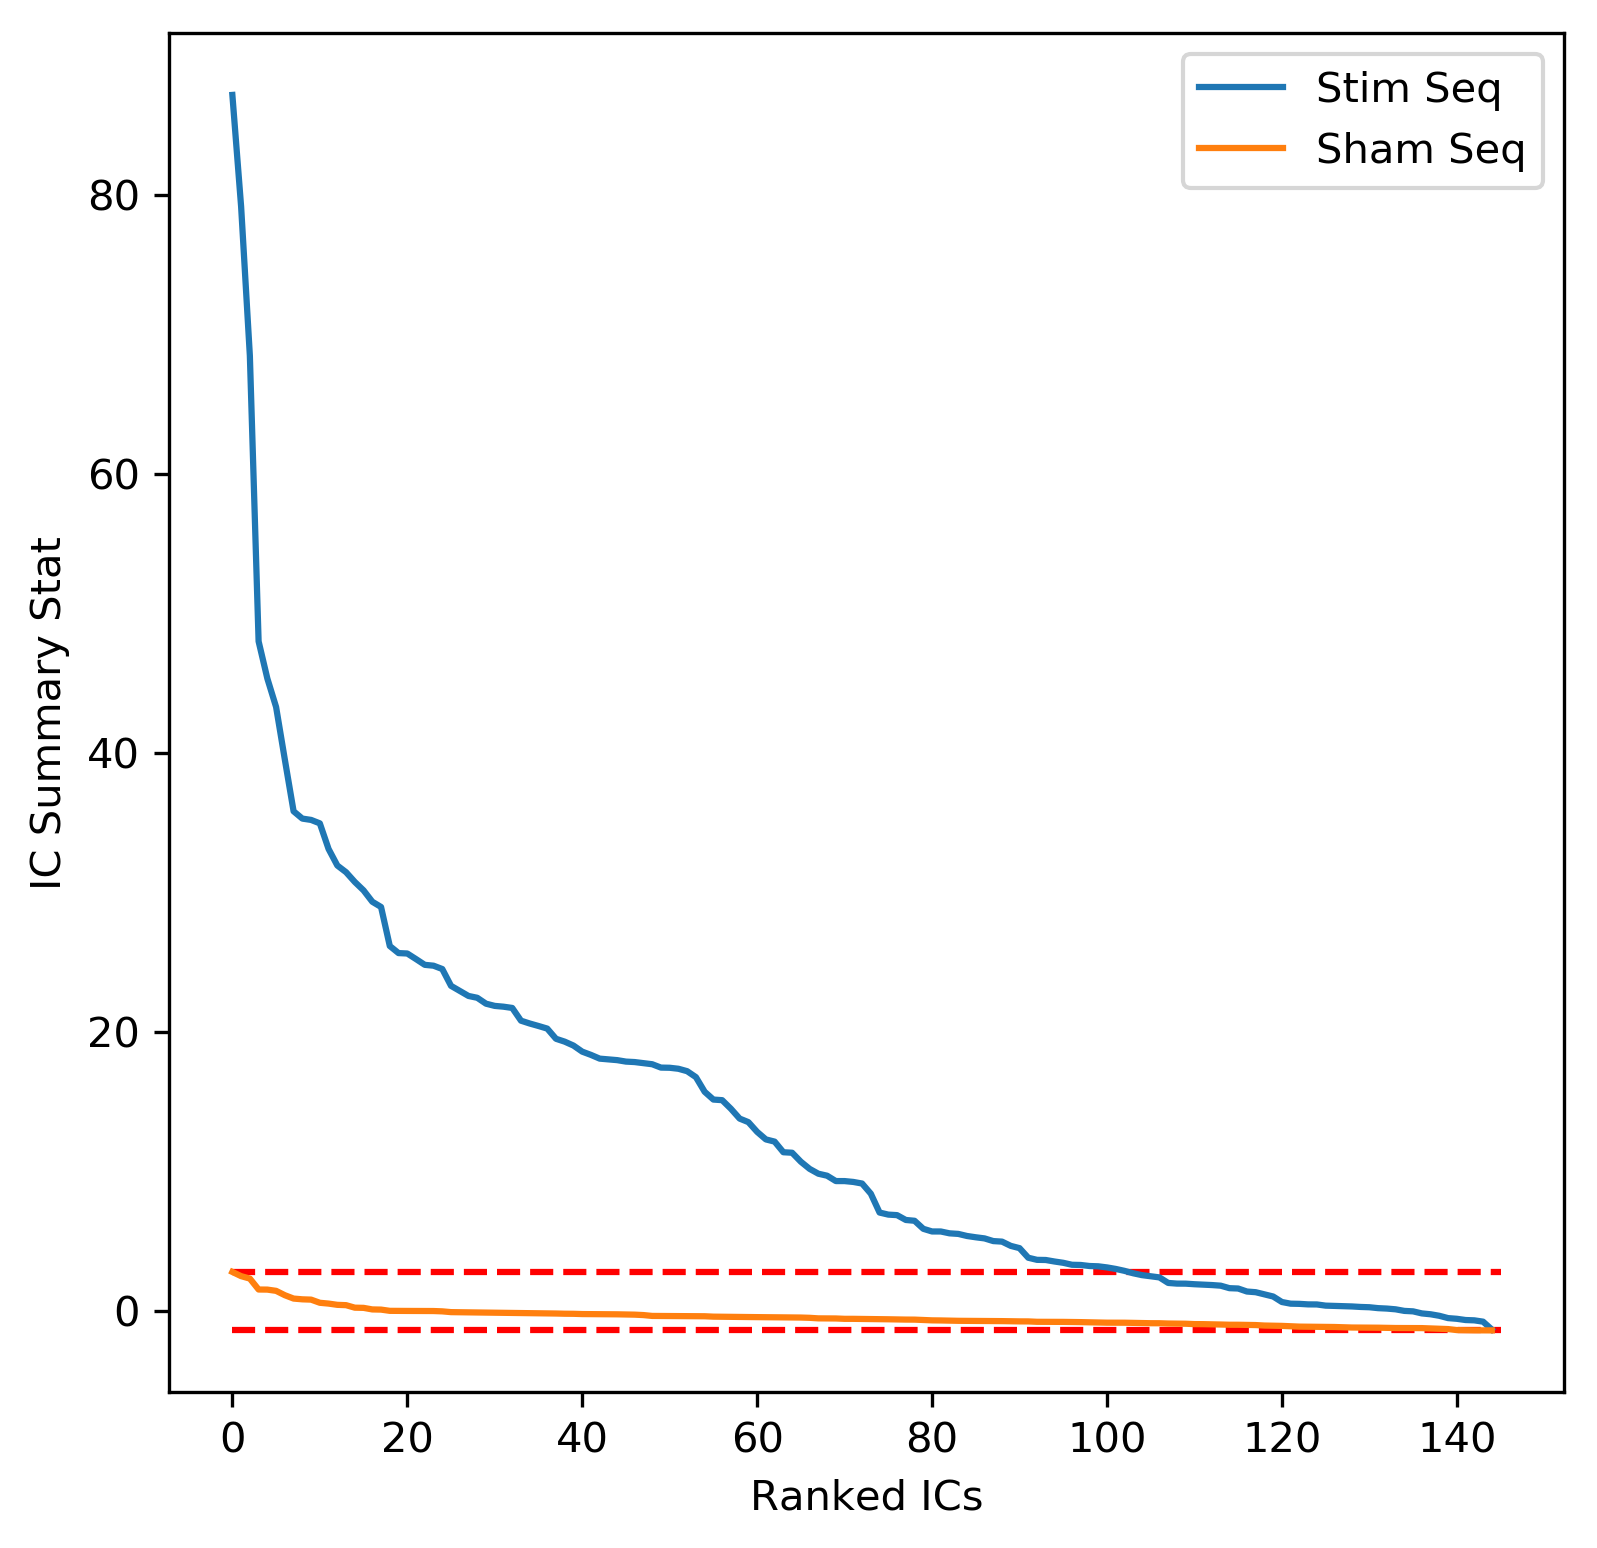

Example iEEG of stim pulses before/after IC removal...


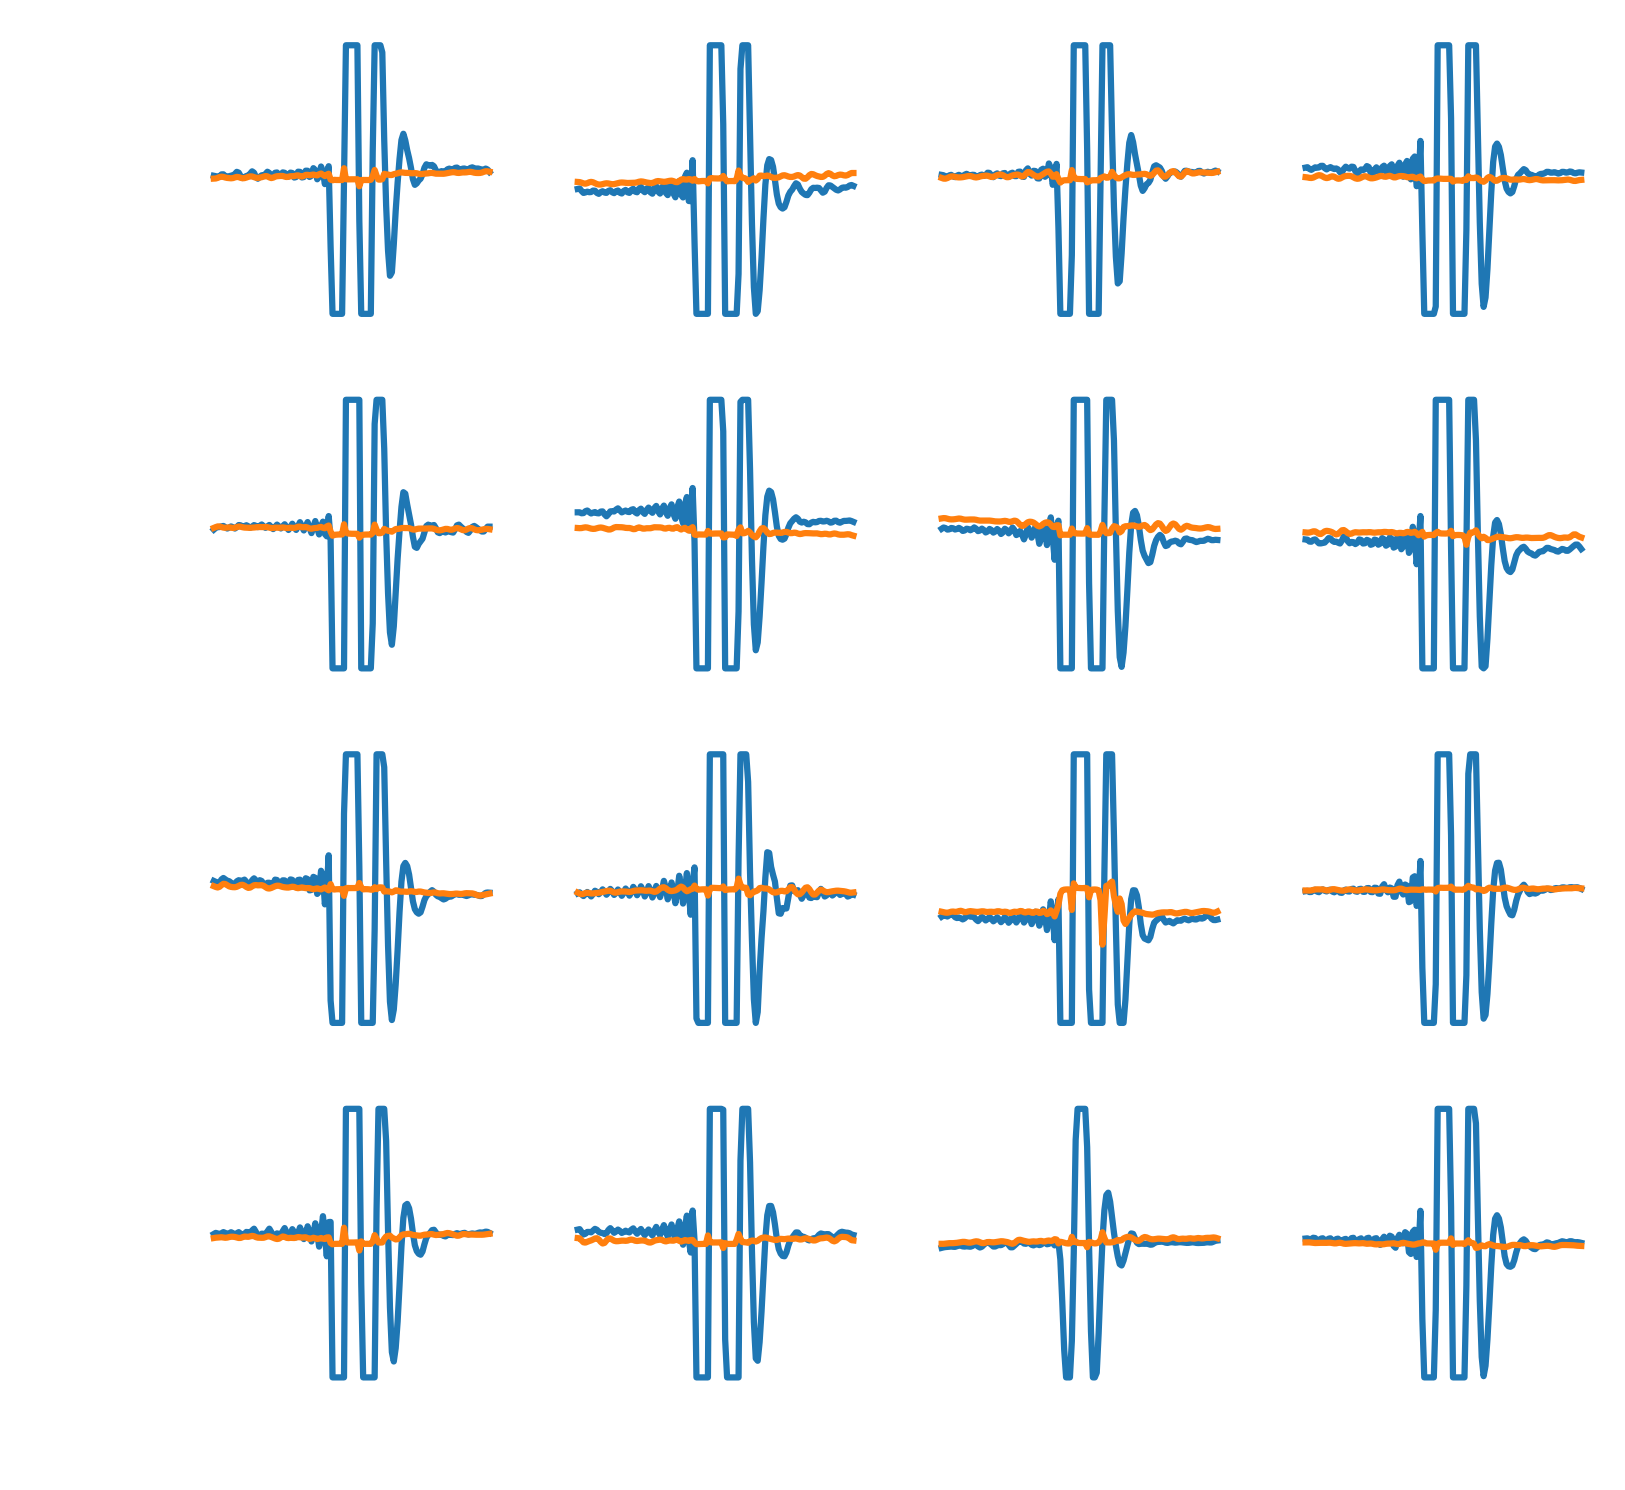

Reconstitute full iEEG with cleaned pulse periods...


In [72]:
signal_cleaned = zappy.elstim.artifact.ica_pulse_reconstruction(
                            signal=sig.copy(),
                            stim_seq=sseq.copy(),
                            amp_range=(0,1),
                            inter_train_len=Fs*8.0,
                            padding=[0, 0],
                            ic_stat_pct=[0, 100],
                            signal_sham=sig_sham.copy(),
                            n_components=None,
                            plot=True)

# Decimate Cleaned Signal

In [52]:
import scipy.signal as sp_sig
signal_cleaned2 = np.convolve(signal_cleaned[:,0], sp_sig.windows.hann(10)/10, mode='same').reshape(-1,1)

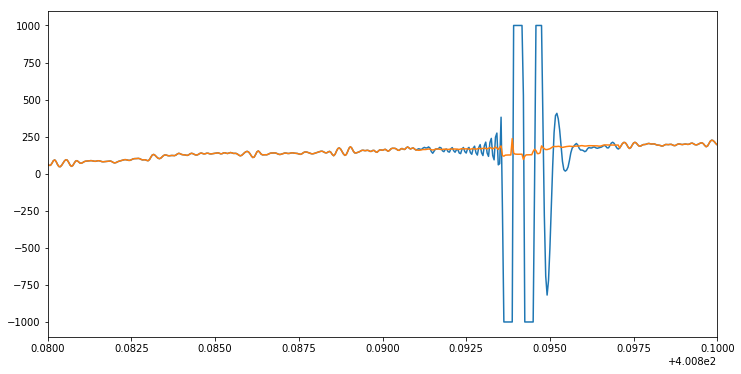

In [81]:
plt.figure(figsize=(12,6))
plt.plot(tstamp, sig[:, 0])
plt.plot(tstamp, signal_cleaned[:, 0])
#plt.xlim([110.210, 110.225])
#plt.xlim([210.7, 211.2])
#plt.xlim([400.7, 401.2])
plt.xlim([400.88, 400.9])
#plt.ylim([-250, 250])
#plt.legend(['Original', 'Zappy'])
plt.show()

Text(0.5, 1.0, 'Zappy')

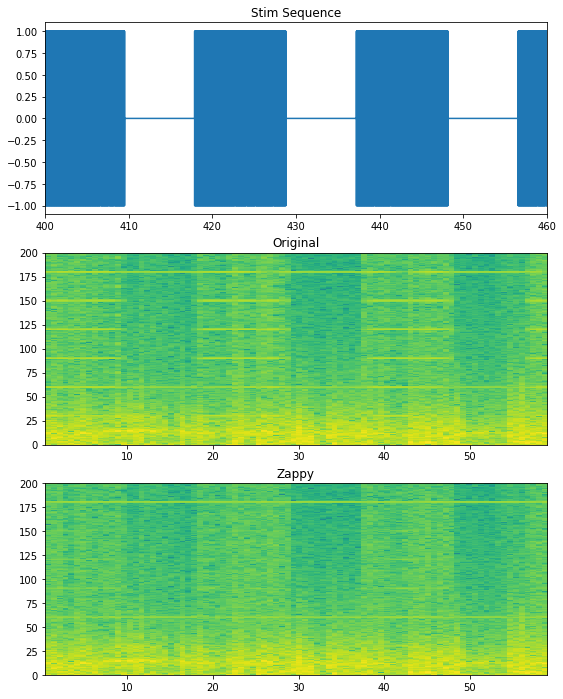

In [89]:
sel_ts = np.flatnonzero((tstamp >= 400) & (tstamp <= 460))

plt.figure(figsize=(9,12))
ax = plt.subplot(3,1,1)
ax.plot(tstamp[sel_ts], sseq[sel_ts, 0])
ax.set_xlim([400, 460])
ax.set_title('Stim Sequence')

ax = plt.subplot(3,1,2)
ax.specgram(sig[sel_ts, 0], Fs=Fs, NFFT=2**15, noverlap=2**14)
ax.set_ylim([0, 200])
#ax.set_xlim([400.88-400, 400.9-400])
ax.set_title('Original')

ax = plt.subplot(3,1,3)
ax.specgram(signal_cleaned[sel_ts, 0], Fs=Fs, NFFT=2**15, noverlap=2**14)
ax.set_ylim([0, 200])
#ax.set_xlim([400.88-400, 400.9-400])
ax.set_title('Zappy')

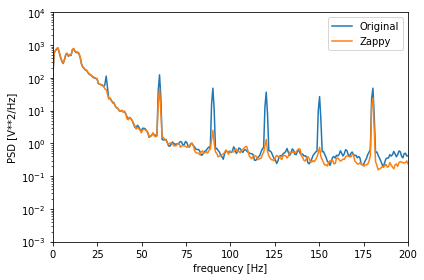

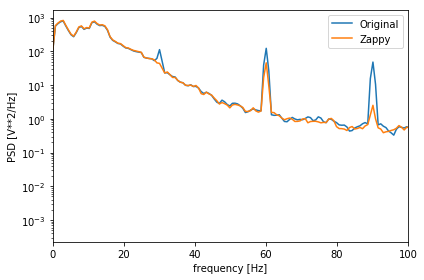

In [90]:
from scipy import signal

f, Pxx_den = signal.welch(sig[sel_ts, 0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(signal_cleaned[sel_ts,0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 200])
plt.ylim([10**(-3), 10**(4)])
plt.tight_layout()
plt.legend(['Original', 'Zappy'])
plt.show()

f, Pxx_den = signal.welch(sig[sel_ts, 0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(signal_cleaned[sel_ts,0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 100])
#plt.ylim([10**(-10), 10**(-7)])
plt.tight_layout()
plt.legend(['Original', 'Zappy'])
plt.show()